<a href="https://colab.research.google.com/github/TuckerArrants/flower-classification/blob/master/KFold_Training_%2B_Hair_Augmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# KFold Training with Hair Augmentation

In [ ]:
!pip install -q efficientnet

In [ ]:
#the basics
import pandas as pd
import numpy as np
import re, os, math
import matplotlib.pyplot as plt

#deep learning
import tensorflow as tf
import tensorflow.keras.backend as K
import efficientnet.tfkeras as efn

#model evaluation
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score

## Initial Configuration

In [ ]:
#select device
DEVICE = "TPU" #or "GPU"

#for debugging
DEBUGGING = False

#set random seed
SEED = 34

#set number of folds
# can be 3, 5, or 15
FOLDS = 3 if DEBUGGING else 5

#choose image sizes for each fold
#options are 128, 192, 256, 384, 512, 768 
IMG_SIZES = [384, 384, 384, 384, 384]

#choose external data to include for each fold
INC2019 = [0,0,0,0,0]
INC2018 = [1,1,1,1,1]

#set batch size and epochs
BATCH_SIZES = [32]*FOLDS
EPOCHS = [1]*FOLDS if DEBUGGING else [10]*FOLDS

#chose EffNet to use on each fold
EFF_NETS = [6,6,6,6,6]

#chosoe how many hairs to add for hair augmentation
N_MAX = 1 if DEBUGGING else 6

#choose weights for folds when predicting
WGTS = [1/FOLDS]*FOLDS

#choose TTA steps
#20 - 25 is as high as you need to go
TTA = 25

#define classes
CLASSES = ['benign', 'malignant']

In [ ]:
#the slowly evolving standard TPU initialization script
if DEVICE == "TPU":
    print("connecting to TPU...")
    try:
        tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
        print('Running on TPU ', tpu.master())
    except ValueError:
        print("Could not connect to TPU")
        tpu = None

    if tpu:
        try:
            print("initializing  TPU ...")
            tf.config.experimental_connect_to_cluster(tpu)
            tf.tpu.experimental.initialize_tpu_system(tpu)
            strategy = tf.distribute.experimental.TPUStrategy(tpu)
            print("TPU initialized")
        except _:
            print("failed to initialize TPU")
    else:
        DEVICE = "GPU"

if DEVICE != "TPU":
    print("Using default strategy for CPU and single GPU")
    strategy = tf.distribute.get_strategy()

if DEVICE == "GPU":
    print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
    

AUTO = tf.data.experimental.AUTOTUNE
REPLICAS = strategy.num_replicas_in_sync
print(f'REPLICAS: {REPLICAS}')

connecting to TPU...
Running on TPU  grpc://10.18.153.82:8470
initializing  TPU ...
INFO:tensorflow:Initializing the TPU system: grpc://10.18.153.82:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.18.153.82:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


TPU initialized
REPLICAS: 8


In [ ]:
#GCS_PATH = [None]*FOLDS; GCS_PATH2 = [None]*FOLDS
#for i,k in enumerate(IMG_SIZES[:FOLDS]):
#    GCS_PATH[i] = KaggleDatasets().get_gcs_path('melanoma-%ix%i'%(k,k))
#    GCS_PATH2[i] = KaggleDatasets().get_gcs_path('isic2019-%ix%i'%(k,k))
#files_train = np.sort(np.array(tf.io.gfile.glob(GCS_PATH[0] + '/train*.tfrec')))
#files_test  = np.sort(np.array(tf.io.gfile.glob(GCS_PATH[0] + '/test*.tfrec')))

#Kaggle has limited TPU quota, so go train on Colabs and manually add GCS
#paths that KaggleDatasets() gives you on a Kaggle kernel
GCS_PATH = ['gs://kds-6763fab01fc2e4f17502b8fe494b1880f0979df6b66ea201721f2672', 'gs://kds-6763fab01fc2e4f17502b8fe494b1880f0979df6b66ea201721f2672', 'gs://kds-6763fab01fc2e4f17502b8fe494b1880f0979df6b66ea201721f2672', 'gs://kds-6763fab01fc2e4f17502b8fe494b1880f0979df6b66ea201721f2672', 'gs://kds-6763fab01fc2e4f17502b8fe494b1880f0979df6b66ea201721f2672']
GCS_PATH2 = ['gs://kds-fc59a9e49338667ebf41c5be0e8e35f9a8b6bead2f5e44ba68a9c1ca', 'gs://kds-fc59a9e49338667ebf41c5be0e8e35f9a8b6bead2f5e44ba68a9c1ca', 'gs://kds-fc59a9e49338667ebf41c5be0e8e35f9a8b6bead2f5e44ba68a9c1ca', 'gs://kds-fc59a9e49338667ebf41c5be0e8e35f9a8b6bead2f5e44ba68a9c1ca', 'gs://kds-fc59a9e49338667ebf41c5be0e8e35f9a8b6bead2f5e44ba68a9c1ca']

files_train = np.sort(np.array(tf.io.gfile.glob(GCS_PATH[0] + '/train*.tfrec')))
files_test  = np.sort(np.array(tf.io.gfile.glob(GCS_PATH[0] + '/test*.tfrec')))

# Rotation Augmentation

**Code taken from Chris Deotte - very similar to the one he wrote for the Flower Classification competition. Performs random shears, rotations, zooms, and shifts that can be used during training as well as during TTA**

In [ ]:
ROT_ = 180.0
SHR_ = 2.0
HZOOM_ = 8.0
WZOOM_ = 8.0
HSHIFT_ = 8.0
WSHIFT_ = 8.0

def get_mat(rotation, shear, height_zoom, width_zoom, height_shift, width_shift):
    # returns 3x3 transformmatrix which transforms indicies
        
    # CONVERT DEGREES TO RADIANS
    rotation = math.pi * rotation / 180.
    shear    = math.pi * shear    / 180.

    def get_3x3_mat(lst):
        return tf.reshape(tf.concat([lst],axis=0), [3,3])
    
    # ROTATION MATRIX
    c1   = tf.math.cos(rotation)
    s1   = tf.math.sin(rotation)
    one  = tf.constant([1],dtype='float32')
    zero = tf.constant([0],dtype='float32')
    
    rotation_matrix = get_3x3_mat([c1,   s1,   zero, 
                                   -s1,  c1,   zero, 
                                   zero, zero, one])    
    # SHEAR MATRIX
    c2 = tf.math.cos(shear)
    s2 = tf.math.sin(shear)    
    
    shear_matrix = get_3x3_mat([one,  s2,   zero, 
                                zero, c2,   zero, 
                                zero, zero, one])        
    # ZOOM MATRIX
    zoom_matrix = get_3x3_mat([one/height_zoom, zero,           zero, 
                               zero,            one/width_zoom, zero, 
                               zero,            zero,           one])    
    # SHIFT MATRIX
    shift_matrix = get_3x3_mat([one,  zero, height_shift, 
                                zero, one,  width_shift, 
                                zero, zero, one])
    
    return K.dot(K.dot(rotation_matrix, shear_matrix), 
                 K.dot(zoom_matrix,     shift_matrix))


def regular_aug(image, DIM=256):    
    # input image - is one image of size [dim,dim,3] not a batch of [b,dim,dim,3]
    # output - image randomly rotated, sheared, zoomed, and shifted
    XDIM = DIM%2 #fix for size 331
    
    rot = ROT_ * tf.random.normal([1], dtype='float32')
    shr = SHR_ * tf.random.normal([1], dtype='float32') 
    h_zoom = 1.0 + tf.random.normal([1], dtype='float32') / HZOOM_
    w_zoom = 1.0 + tf.random.normal([1], dtype='float32') / WZOOM_
    h_shift = HSHIFT_ * tf.random.normal([1], dtype='float32') 
    w_shift = WSHIFT_ * tf.random.normal([1], dtype='float32') 

    # GET TRANSFORMATION MATRIX
    m = get_mat(rot,shr,h_zoom,w_zoom,h_shift,w_shift) 

    # LIST DESTINATION PIXEL INDICES
    x   = tf.repeat(tf.range(DIM//2, -DIM//2,-1), DIM)
    y   = tf.tile(tf.range(-DIM//2, DIM//2), [DIM])
    z   = tf.ones([DIM*DIM], dtype='int32')
    idx = tf.stack( [x,y,z] )
    
    # ROTATE DESTINATION PIXELS ONTO ORIGIN PIXELS
    idx2 = K.dot(m, tf.cast(idx, dtype='float32'))
    idx2 = K.cast(idx2, dtype='int32')
    idx2 = K.clip(idx2, -DIM//2+XDIM+1, DIM//2)
    
    # FIND ORIGIN PIXEL VALUES           
    idx3 = tf.stack([DIM//2-idx2[0,], DIM//2-1+idx2[1,]])
    d    = tf.gather_nd(image, tf.transpose(idx3))
        
    return tf.reshape(d,[DIM, DIM,3])

# Hair Augmentation

In [ ]:
#GCS_PATH_HAIRS = KaggleDatasets().get_gcs_path('melanoma-hairs')
GCS_PATH_HAIRS = 'gs://kds-6e6c080ddb488bce76c3ec50367c9f2531de7c2c2c689ba262a196a6'
hair_images=tf.io.gfile.glob(GCS_PATH_HAIRS + '/*.png')

hair_images_tf=tf.convert_to_tensor(hair_images)

In [ ]:
def hair_aug(img, DIM = 256):
    #scale
    scale=tf.cast(DIM/256, dtype=tf.int32)
    # Copy the input image, so it won't be changed
    img1=img
    # Randomly choose the number of hairs to augment (up to n_max)
    n_hairs = tf.random.uniform(shape=[], maxval=tf.constant(N_MAX)+1, 
                                dtype=tf.int32)
    
    im_height=tf.shape(img1)[1]
    im_width=tf.shape(img1)[0]
    
    if n_hairs == 0:
        return img

    for _ in tf.range(n_hairs):

        # Read a random hair image
        i=tf.random.uniform(shape=[], maxval=tf.shape(hair_images_tf)[0], 
                            dtype=tf.int32)
        fname=hair_images_tf[i]

        bits = tf.io.read_file(fname)
        hair = tf.image.decode_jpeg(bits)
        
        # Rescale the hair image to the right size (256 -- original size)
        new_width=scale*tf.shape(hair)[1]
        new_height=scale*tf.shape(hair)[0]
        hair = tf.image.resize(hair, [new_height, new_width])

        
        # Random flips of the hair image
        hair = tf.image.random_flip_left_right(hair)
        hair = tf.image.random_flip_up_down(hair)
        # Random number of 90 degree rotations
        n_rot=tf.random.uniform(shape=[], maxval=4,
                                dtype=tf.int32)
        hair = tf.image.rot90(hair, k=n_rot)
        
        h_height=tf.shape(hair)[0]
        h_width=tf.shape(hair)[1]
        
        roi_h0 = tf.random.uniform(shape=[], maxval=im_height - h_height + 1, 
                                    dtype=tf.int32)
        roi_w0 = tf.random.uniform(shape=[], maxval=im_width - h_width + 1, 
                                    dtype=tf.int32)


        roi = img1[roi_h0:(roi_h0 + h_height), roi_w0:(roi_w0 + h_width)]  

        # Convert the hair image to grayscale 
        # (slice to remove the trainsparency channel)
        hair2gray = tf.image.rgb_to_grayscale(hair[:, :, :3])

        mask=hair2gray>10

        img_bg = tf.multiply(roi, tf.cast(tf.image.grayscale_to_rgb(~mask),
                                          dtype=tf.float32))
        hair_fg = tf.multiply(tf.cast(hair[:, :, :3], dtype=tf.int32),
                              tf.cast(tf.image.grayscale_to_rgb(mask), 
                                      dtype=tf.int32
                                      )
                             )

        dst = tf.add(img_bg, tf.cast(hair_fg, dtype=tf.float32)/255)

        paddings = tf.stack([
            [roi_h0, im_height-(roi_h0 + h_height)], 
            [roi_w0, im_width-(roi_w0 + h_width)],
            [0, 0]
        ])

        # Pad dst with zeros to make it the same shape as image.
        dst_padded=tf.pad(dst, paddings, "CONSTANT")
        # Create a boolean mask with zeros at the pixels of
        # the augmentation segment and ones everywhere else
        mask_img=tf.pad(tf.ones_like(dst), paddings, "CONSTANT")
        mask_img=~tf.cast(mask_img, dtype=tf.bool)
        # Make a hole in the original image at the location
        # of the augmentation segment
        img_hole=tf.multiply(img1, tf.cast(mask_img, dtype=tf.float32))
        # Inserting the augmentation segment in place of the hole
        img=tf.add(img_hole, dst_padded)
        
    return tf.reshape(img1,[DIM, DIM,3])

In [ ]:
def read_labeled_tfrecord(example):
    tfrec_format = {
        'image'                        : tf.io.FixedLenFeature([], tf.string),
        'image_name'                   : tf.io.FixedLenFeature([], tf.string),
        'patient_id'                   : tf.io.FixedLenFeature([], tf.int64),
        'sex'                          : tf.io.FixedLenFeature([], tf.int64),
        'age_approx'                   : tf.io.FixedLenFeature([], tf.int64),
        'anatom_site_general_challenge': tf.io.FixedLenFeature([], tf.int64),
        'diagnosis'                    : tf.io.FixedLenFeature([], tf.int64),
        'target'                       : tf.io.FixedLenFeature([], tf.int64)
    }           
    example = tf.io.parse_single_example(example, tfrec_format)
    return example['image'], example['target']


def read_unlabeled_tfrecord(example, return_image_name):
    tfrec_format = {
        'image'                        : tf.io.FixedLenFeature([], tf.string),
        'image_name'                   : tf.io.FixedLenFeature([], tf.string),
    }
    example = tf.io.parse_single_example(example, tfrec_format)
    return example['image'], example['image_name'] if return_image_name else 0

 
def prepare_image(img, augment=True, dim=256):    
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.cast(img, tf.float32) / 255.0
    
    if augment:
        #applies hair augmentation
        #img = hair_aug(img, DIM = dim)

        #applies rotation/shear/shift/etc augmentation
        img = regular_aug(img, DIM = dim)

        #some extra augmentations we can perform easily with tf.image
        #orientation
        img = tf.image.random_flip_left_right(img)
        #img = tf.image.random_flip_up_down(img)

        #pixel effects
        #img = tf.image.random_hue(img, 0.02)
        img = tf.image.random_saturation(img, 0.7, 1.3)
        img = tf.image.random_contrast(img, 0.8, 1.2)
        img = tf.image.random_brightness(img, 0.1)
           
    return tf.reshape(img, [dim,dim, 3])      
 

def count_data_items(filenames):
    return np.sum([int(re.compile(r"-([0-9]*)\.").search(filename).group(1)) for filename in filenames])

In [ ]:
def get_dataset(files, augment = False, do_hair_aug = True, shuffle = False, repeat = False, 
                labeled=True, return_image_names=True, batch_size=16, dim=256):
    
    ds = tf.data.TFRecordDataset(files, num_parallel_reads=AUTO)
    ds = ds.cache()
    
    if repeat:
        ds = ds.repeat()
    
    if shuffle: 
        ds = ds.shuffle(1024*8)
        opt = tf.data.Options()
        opt.experimental_deterministic = False
        ds = ds.with_options(opt)
        
    if labeled: 
        ds = ds.map(read_labeled_tfrecord, num_parallel_calls=AUTO)
    else:
        ds = ds.map(lambda example: read_unlabeled_tfrecord(example, return_image_names), 
                    num_parallel_calls=AUTO)  
        

    ds = ds.map(lambda img, imgname_or_label: (prepare_image(img, augment=augment, dim=dim), 
                                               imgname_or_label), 
                num_parallel_calls=AUTO)
    
    ds = ds.batch(batch_size * REPLICAS)
    ds = ds.prefetch(AUTO)
    return ds

# Model Training

In [ ]:
EFNS = [efn.EfficientNetB0, efn.EfficientNetB1, efn.EfficientNetB2, efn.EfficientNetB3, 
        efn.EfficientNetB4, efn.EfficientNetB5, efn.EfficientNetB6]

def build_model(dim=128, ef=0):
    inp = tf.keras.layers.Input(shape=(dim,dim,3))
    base = EFNS[ef](input_shape=(dim,dim,3),weights='imagenet',include_top=False)
    x = base(inp)
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dropout(.2)(x)
    x = tf.keras.layers.Dense(1,activation='sigmoid')(x)
    model = tf.keras.Model(inputs=inp,outputs=x)
    opt = tf.keras.optimizers.Adam(learning_rate=0.001)
    loss = tf.keras.losses.BinaryCrossentropy(label_smoothing=0.05) 
    model.compile(optimizer=opt,loss=loss,metrics=['AUC'])
    return model

# Train Schedule

**A standard learning rate callback for transfer learning. It is standard practice to scale the learning rate with the batch_size**

In [ ]:
def get_lr_callback(batch_size=8):
    lr_start   = 0.000005
    lr_max     = 0.00000125 * REPLICAS * batch_size
    lr_min     = 0.000001
    lr_ramp_ep = 5
    lr_sus_ep  = 0
    lr_decay   = 0.8
   
    def lrfn(epoch):
        if epoch < lr_ramp_ep:
            lr = (lr_max - lr_start) / lr_ramp_ep * epoch + lr_start
            
        elif epoch < lr_ramp_ep + lr_sus_ep:
            lr = lr_max
            
        else:
            lr = (lr_max - lr_min) * lr_decay**(epoch - lr_ramp_ep - lr_sus_ep) + lr_min
            
        return lr

    lr_callback = tf.keras.callbacks.LearningRateScheduler(lrfn, verbose=False)
    return lr_callback

## And Here We Go

INFO:tensorflow:Initializing the TPU system: grpc://10.18.153.82:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.18.153.82:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


#########################
#### FOLD 1
#### Image Size 384 with EfficientNet B6 and batch_size 256
#### Using 2018+2017 external data
#########################
Training...
Epoch 1/10
Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Instructions for updating:
If using Keras pass *_constraint arguments to layers.


142/142 - 215s - auc: 0.5733 - loss: 0.6109 - val_auc: 0.6805 - val_loss: 0.4946 - lr: 5.0000e-06
Epoch 2/10
142/142 - 176s - auc: 0.7939 - loss: 0.2466 - val_auc: 0.8316 - val_loss: 0.1667 - lr: 6.8000e-05
Epoch 3/10
142/142 - 170s - auc: 0.8758 - loss: 0.2216 - val_auc: 0.8653 - val_loss: 0.1680 - lr: 1.3100e-04
Epoch 4/10
142/142 - 176s - auc: 0.8981 - loss: 0.2135 - val_auc: 0.8719 - val_loss: 0.1654 - lr: 1.9400e-04
Epoch 5/10
142/142 - 170s - auc: 0.9067 - loss: 0.2111 - val_auc: 0.8912 - val_loss: 0.1662 - lr: 2.5700e-04
Epoch 6/10
142/142 - 176s - auc: 0.9222 - loss: 0.2023 - val_auc: 0.9021 - val_loss: 0.1640 - lr: 3.2000e-04
Epoch 7/10
142/142 - 170s - auc: 0.9351 - loss: 0.1954 - val_auc: 0.9077 - val_loss: 0.1650 - lr: 2.5620e-04
Epoch 8/10
142/142 - 171s - auc: 0.9478 - loss: 0.1911 - val_auc: 0.9187 - val_loss: 0.1666 - lr: 2.0516e-04
Epoch 9/10
142/142 - 176s - auc: 0.9523 - loss: 0.1843 - val_auc: 0.9204 - val_loss: 0.1606 - lr: 1.6433e-04
Epoch 10/10
142/142 - 176s - a

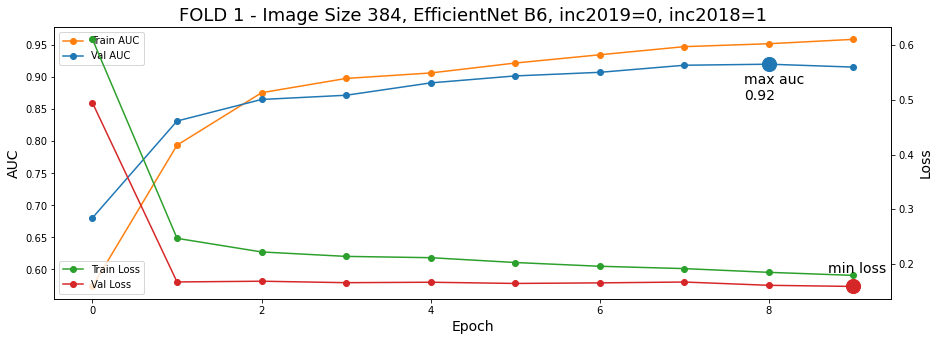

INFO:tensorflow:Initializing the TPU system: grpc://10.18.153.82:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.18.153.82:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


#########################
#### FOLD 2
#### Image Size 384 with EfficientNet B6 and batch_size 256
#### Using 2018+2017 external data
#########################
Training...
Epoch 1/10
142/142 - 206s - auc: 0.5904 - loss: 0.5963 - val_auc: 0.6319 - val_loss: 0.4161 - lr: 5.0000e-06
Epoch 2/10
142/142 - 176s - auc: 0.7949 - loss: 0.2457 - val_auc: 0.8301 - val_loss: 0.1668 - lr: 6.8000e-05
Epoch 3/10
142/142 - 175s - auc: 0.8806 - loss: 0.2200 - val_auc: 0.8764 - val_loss: 0.1638 - lr: 1.3100e-04
Epoch 4/10
142/142 - 176s - auc: 0.8991 - loss: 0.2136 - val_auc: 0.8878 - val_loss: 0.1621 - lr: 1.9400e-04
Epoch 5/10
142/142 - 171s - auc: 0.9132 - loss: 0.2087 - val_auc: 0.8932 - val_loss: 0.1630 - lr: 2.5700e-04
Epoch 6/10
142/142 - 170s - auc: 0.9221 - loss: 0.2028 - val_auc: 0.8489 - val_loss: 0.1629 - lr: 3.2000e-04
Epoch 7/10
142/142 - 176s - auc: 0.9396 - loss: 0.1964 - val_auc: 0.8649 - val_loss: 0.1611 - lr: 2.5620e-04
Epoch 8/10
142/142 - 171s - auc: 0.9474 - loss: 0.1880 - val_auc: 

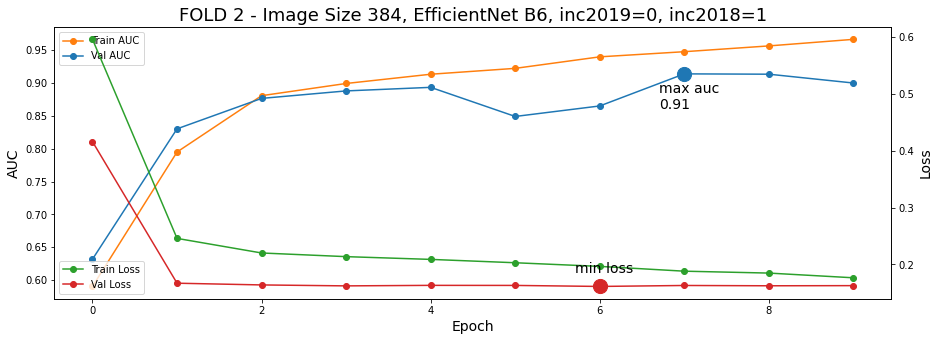

INFO:tensorflow:Initializing the TPU system: grpc://10.18.153.82:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.18.153.82:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


#########################
#### FOLD 3
#### Image Size 384 with EfficientNet B6 and batch_size 256
#### Using 2018+2017 external data
#########################
Training...
Epoch 1/10
142/142 - 198s - auc: 0.5639 - loss: 0.6018 - val_auc: 0.6119 - val_loss: 0.5564 - lr: 5.0000e-06
Epoch 2/10
142/142 - 176s - auc: 0.7980 - loss: 0.2452 - val_auc: 0.8431 - val_loss: 0.1707 - lr: 6.8000e-05
Epoch 3/10
142/142 - 171s - auc: 0.8764 - loss: 0.2229 - val_auc: 0.8854 - val_loss: 0.1709 - lr: 1.3100e-04
Epoch 4/10
142/142 - 177s - auc: 0.8998 - loss: 0.2125 - val_auc: 0.8844 - val_loss: 0.1678 - lr: 1.9400e-04
Epoch 5/10
142/142 - 175s - auc: 0.9122 - loss: 0.2083 - val_auc: 0.8915 - val_loss: 0.1641 - lr: 2.5700e-04
Epoch 6/10
142/142 - 176s - auc: 0.9203 - loss: 0.2044 - val_auc: 0.9070 - val_loss: 0.1632 - lr: 3.2000e-04
Epoch 7/10
142/142 - 177s - auc: 0.9350 - loss: 0.1962 - val_auc: 0.8903 - val_loss: 0.1601 - lr: 2.5620e-04
Epoch 8/10
142/142 - 171s - auc: 0.9473 - loss: 0.1885 - val_auc: 

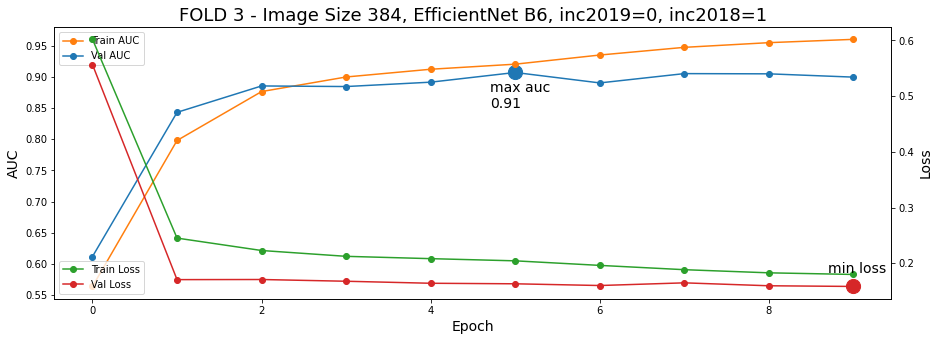

INFO:tensorflow:Initializing the TPU system: grpc://10.18.153.82:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.18.153.82:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


#########################
#### FOLD 4
#### Image Size 384 with EfficientNet B6 and batch_size 256
#### Using 2018+2017 external data
#########################
Training...
Epoch 1/10
142/142 - 196s - auc: 0.5416 - loss: 0.6098 - val_auc: 0.6720 - val_loss: 0.4181 - lr: 5.0000e-06
Epoch 2/10
142/142 - 177s - auc: 0.7858 - loss: 0.2465 - val_auc: 0.8412 - val_loss: 0.1687 - lr: 6.8000e-05
Epoch 3/10
142/142 - 178s - auc: 0.8814 - loss: 0.2205 - val_auc: 0.8486 - val_loss: 0.1644 - lr: 1.3100e-04
Epoch 4/10
142/142 - 178s - auc: 0.9001 - loss: 0.2136 - val_auc: 0.8634 - val_loss: 0.1642 - lr: 1.9400e-04
Epoch 5/10
142/142 - 172s - auc: 0.9100 - loss: 0.2093 - val_auc: 0.8833 - val_loss: 0.1693 - lr: 2.5700e-04
Epoch 6/10
142/142 - 178s - auc: 0.9187 - loss: 0.2030 - val_auc: 0.8808 - val_loss: 0.1615 - lr: 3.2000e-04
Epoch 7/10
142/142 - 172s - auc: 0.9343 - loss: 0.1962 - val_auc: 0.8950 - val_loss: 0.1708 - lr: 2.5620e-04
Epoch 8/10
142/142 - 177s - auc: 0.9455 - loss: 0.1910 - val_auc: 

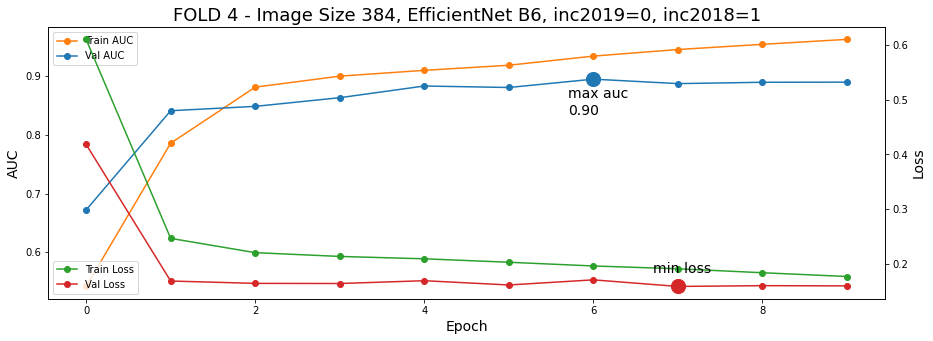

INFO:tensorflow:Initializing the TPU system: grpc://10.18.153.82:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.18.153.82:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


#########################
#### FOLD 5
#### Image Size 384 with EfficientNet B6 and batch_size 256
#### Using 2018+2017 external data
#########################
Training...
Epoch 1/10
142/142 - 208s - auc: 0.5863 - loss: 0.6081 - val_auc: 0.5712 - val_loss: 0.4961 - lr: 5.0000e-06
Epoch 2/10
142/142 - 176s - auc: 0.8025 - loss: 0.2449 - val_auc: 0.8263 - val_loss: 0.1722 - lr: 6.8000e-05
Epoch 3/10
142/142 - 172s - auc: 0.8846 - loss: 0.2189 - val_auc: 0.8691 - val_loss: 0.1726 - lr: 1.3100e-04
Epoch 4/10


In [ ]:
VERBOSE = 2
DISPLAY_PLOT = True

skf = KFold(n_splits=FOLDS,shuffle=True,random_state=SEED)
oof_pred = []; oof_tar = []; oof_val = []; oof_names = []; oof_folds = [] 
preds = np.zeros((count_data_items(files_test),1))

for fold,(idxT,idxV) in enumerate(skf.split(np.arange(15))):
    
    #display fold info
    if DEVICE=='TPU':
        if tpu: tf.tpu.experimental.initialize_tpu_system(tpu)
    print('#'*25); print('#### FOLD',fold+1)
    print('#### Image Size %i with EfficientNet B%i and batch_size %i'%
          (IMG_SIZES[fold],EFF_NETS[fold],BATCH_SIZES[fold]*REPLICAS))
    
    #get training files
    files_train = tf.io.gfile.glob([GCS_PATH[fold] + '/train%.2i*.tfrec'%x for x in idxT])

    #add 2019 comp data
    if INC2019[fold]:
        files_train += tf.io.gfile.glob([GCS_PATH2[fold] + '/train%.2i*.tfrec'%x for x in idxT*2+1])
        print('#### Using 2019 external data')

    #add 2017+2018 comp data
    if INC2018[fold]:
        files_train += tf.io.gfile.glob([GCS_PATH2[fold] + '/train%.2i*.tfrec'%x for x in idxT*2])
        print('#### Using 2018+2017 external data')
    np.random.shuffle(files_train); print('#'*25)
    files_valid = tf.io.gfile.glob([GCS_PATH[fold] + '/train%.2i*.tfrec'%x for x in idxV])
    files_test = np.sort(np.array(tf.io.gfile.glob(GCS_PATH[fold] + '/test*.tfrec')))
    
    #build model
    K.clear_session()
    with strategy.scope():
        model = build_model(dim=IMG_SIZES[fold],ef=EFF_NETS[fold])
        
    #save only best models from the folds
    sv = tf.keras.callbacks.ModelCheckpoint(
        'fold-%i.h5'%fold, monitor='val_loss', verbose=0, save_best_only=True,
        save_weights_only=True, mode='min', save_freq='epoch')
   
    #and train
    print('Training...')
    history = model.fit(
        get_dataset(files_train, augment=True, shuffle=True, repeat=True,
                dim=IMG_SIZES[fold], batch_size = BATCH_SIZES[fold]), 
        epochs=EPOCHS[fold], callbacks = [sv,get_lr_callback(BATCH_SIZES[fold])], 
        steps_per_epoch=count_data_items(files_train)/BATCH_SIZES[fold]//REPLICAS,
        validation_data=get_dataset(files_valid,augment=False,shuffle=False,
                repeat=False,dim=IMG_SIZES[fold]), #class_weight = {0:1,1:2},
        verbose=VERBOSE
    )
    
    print('Loading best model...')
    model.load_weights('fold-%i.h5'%fold)
    
    #get out of fold predictions
    print('Predicting OOF with TTA...')
    ds_valid = get_dataset(files_valid,labeled=False,return_image_names=False,augment=True,
            repeat=True,shuffle=False,dim=IMG_SIZES[fold],batch_size=BATCH_SIZES[fold]*4)
    ct_valid = count_data_items(files_valid); STEPS = TTA * ct_valid/BATCH_SIZES[fold]/4/REPLICAS
    pred = model.predict(ds_valid,steps=STEPS,verbose=VERBOSE)[:TTA*ct_valid,] 
    oof_pred.append( np.mean(pred.reshape((ct_valid,TTA),order='F'),axis=1) )                 
    #oof_pred.append(model.predict(get_dataset(files_valid,dim=IMG_SIZES[fold]),verbose=1))
    
    #get out of fold targets and names for later
    ds_valid = get_dataset(files_valid, augment=False, repeat=False, dim=IMG_SIZES[fold],
            labeled=True, return_image_names=True)
    oof_tar.append( np.array([target.numpy() for img, target in iter(ds_valid.unbatch())]) )
    oof_folds.append( np.ones_like(oof_tar[-1],dtype='int8')*fold )
    ds = get_dataset(files_valid, augment=False, repeat=False, dim=IMG_SIZES[fold],
                labeled=False, return_image_names=True)
    oof_names.append( np.array([img_name.numpy().decode("utf-8") for img, img_name in iter(ds.unbatch())]))
    
    #predict test with test time augmentation
    print('Predicting Test with TTA...')
    ds_test = get_dataset(files_test,labeled=False,return_image_names=False,augment=True,
            repeat=True,shuffle=False,dim=IMG_SIZES[fold],batch_size=BATCH_SIZES[fold]*4)
    ct_test = count_data_items(files_test); STEPS = TTA * ct_test/BATCH_SIZES[fold]/4/REPLICAS
    pred = model.predict(ds_test,steps=STEPS,verbose=VERBOSE)[:TTA*ct_test,] 
    preds[:,0] += np.mean(pred.reshape((ct_test,TTA),order='F'),axis=1) * WGTS[fold]
    
    # REPORT RESULTS
    auc = roc_auc_score(oof_tar[-1],oof_pred[-1])
    oof_val.append(np.max( history.history['val_auc'] ))
    print('#### FOLD %i OOF AUC without TTA = %.3f, with TTA = %.3f'%(fold+1,oof_val[-1],auc))
    
    # PLOT TRAINING
    if DISPLAY_PLOT:
        plt.figure(figsize=(15,5))
        plt.plot(np.arange(EPOCHS[fold]),history.history['auc'],'-o',label='Train AUC',color='#ff7f0e')
        plt.plot(np.arange(EPOCHS[fold]),history.history['val_auc'],'-o',label='Val AUC',color='#1f77b4')
        x = np.argmax( history.history['val_auc'] ); y = np.max( history.history['val_auc'] )
        xdist = plt.xlim()[1] - plt.xlim()[0]; ydist = plt.ylim()[1] - plt.ylim()[0]
        plt.scatter(x,y,s=200,color='#1f77b4'); plt.text(x-0.03*xdist,y-0.13*ydist,'max auc\n%.2f'%y,size=14)
        plt.ylabel('AUC',size=14); plt.xlabel('Epoch',size=14)
        plt.legend(loc=2)
        plt2 = plt.gca().twinx()
        plt2.plot(np.arange(EPOCHS[fold]),history.history['loss'],'-o',label='Train Loss',color='#2ca02c')
        plt2.plot(np.arange(EPOCHS[fold]),history.history['val_loss'],'-o',label='Val Loss',color='#d62728')
        x = np.argmin( history.history['val_loss'] ); y = np.min( history.history['val_loss'] )
        ydist = plt.ylim()[1] - plt.ylim()[0]
        plt.scatter(x,y,s=200,color='#d62728'); plt.text(x-0.03*xdist,y+0.05*ydist,'min loss',size=14)
        plt.ylabel('Loss',size=14)
        plt.title('FOLD %i - Image Size %i, EfficientNet B%i, inc2019=%i, inc2018=%i'%
                (fold+1,IMG_SIZES[fold],EFF_NETS[fold],INC2019[fold],INC2018[fold]),size=18)
        plt.legend(loc=3)
        plt.show()  

## Calculate OOF AUC


In [ ]:
#computer overall oof AUC
oof = np.concatenate(oof_pred); true = np.concatenate(oof_tar);
names = np.concatenate(oof_names); folds = np.concatenate(oof_folds)
auc = roc_auc_score(true,oof)
print('Overall OOF AUC with TTA = %.3f'%auc)

#save results so we can find best blends
df_oof = pd.DataFrame(dict(
    image_name = names, target=true, pred = oof, fold=folds))
df_oof.to_csv('oof.csv',index=False)
df_oof.head()

In [ ]:
from sklearn.metrics import roc_auc_score
oof = pd.read_csv('oof.csv')

for fold in range(FOLDS):
    print( f'Fold {fold} ROC AUC score:' roc_auc_score(oof.loc[oof.fold==fold].target, oof.loc[oof.fold==fold].pred) )

# Post process
Where to add external tabular data

# Submit To Kaggle

In [ ]:
ds = get_dataset(files_test, augment=False, repeat=False, dim=IMG_SIZES[fold],
                 labeled=False, return_image_names=True)

image_names = np.array([img_name.numpy().decode("utf-8") 
                        for img, img_name in iter(ds.unbatch())])

In [ ]:
submission = pd.DataFrame(dict(image_name=image_names, target=preds[:,0]))
submission = submission.sort_values('image_name') 
submission.to_csv('submission.csv', index=False)
submission.head(10)